#### MULTI-CLASS IMAGE CLASSIFICATION

1. Generate the dataset. Preprocess the data (get it ready for a model)
2. Create a model (start with a baseline)
3. Fit the model (overfit it to make sure it works)
4. Evaluate the model
5. Adjust different hyperparameters and improve the model (try to beat baseline/reduce overfitting)
6. Repeat until satisfied

#### 1. GENERATING THE DATASET

In [ ]:
import zipfile
import gdown

# download the dataset
url = "https://drive.google.com/u/0/uc?id=1GTK3NwzQscKO3zxRk0R8SHoT9EXV_TvS&export=download"
output = "dataset.zip"
gdown.download(url, output)

# unzip the downloaded dataset
zip_ref = zipfile.ZipFile("dataset.zip")
zip_ref.extractall()
zip_ref.close()

Downloading...
From: https://drive.google.com/u/0/uc?id=1GTK3NwzQscKO3zxRk0R8SHoT9EXV_TvS&export=download
To: /content/dataset.zip
100%|██████████| 199M/199M [00:04<00:00, 44.7MB/s]


### 2. INSPECTING THE DATA

In [ ]:
# Setup the train and test directories
train_dir = "dataset/train/"
test_dir = "dataset/test"

In [ ]:
import pathlib
import numpy as np

# Let's get the class names
data_dir = pathlib.Path(train_dir)
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
print(class_names)

['australoid' 'caucasoid' 'mongoloid' 'negroid' 'others']


In [ ]:
# Visiualizing the data
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


# View a random image from the training dataset
def view_random_image(target_dir, target_class):
    # Setup the target directory we'll vie images from:
    target_folder = target_dir+target_class

    # Get a random image path
    random_image = random.sample(os.listdir(target_folder), 1)
    print(random_image)

    # Read in the image and plot it using matplotlib
    img = mpimg.imread(target_folder + "/" + random_image[0])
    plt.imshow(img)
    plt.title(target_class)
    plt.axis("off");

    # Show the shape of the image
    print(f"Image shape: {img.shape}")
    
    return img

['26_0_4_20170117153025829.jpg.chip.jpg']
Image shape: (200, 200, 3)


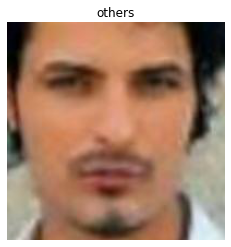

In [ ]:
# View a random image from the training dataset
img = view_random_image(target_dir=train_dir, target_class=random.choice(class_names))

### 3. BUILDING A CONVULUTIONAL NEURAL NETWORK

In [ ]:
# Building a CNN (Convulational Neural Network) to find patterns in our images, more specifically we need a way to:
# 1) Load our images
# 2) Preprocess our images, into something like this => [0.09411765, 0.02745098, 0.25882353]
# 3) Build a CNN to find patterns in our images
# 4) Compile our CNN 
# 5) Fit the CNN to our Training data

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# set the seed
tf.random.set_seed(42)

# Rescale / Preprocess data - get all of the pixel values between 0 & 1, also called scaling/normalization)
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)


# Import data from directories and turn it into batches
train_data = train_datagen.flow_from_directory(train_dir,  
                                               target_size=(224, 224),
                                               batch_size=32,
                                               class_mode="categorical")

test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=(224, 224), 
                                             batch_size=32, 
                                             class_mode="categorical")

Found 20233 images belonging to 5 classes.
Found 4364 images belonging to 5 classes.


CREATING A MODEL

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Activation

# Create model
model_1 = Sequential([
    Conv2D(10, 3, input_shape=(224, 224, 3)),
    Activation(activation="relu"),
    Conv2D(10, 3, activation="relu"),
    MaxPool2D(),
    Conv2D(10, 3, activation="relu"),
    Conv2D(10, 3, activation="relu"),
    MaxPool2D(),
    Flatten(),
    Dense(10, activation="softmax") # changed to have 10 output neurons and use the softmax activation function
])

# Compile the model
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

### 4. FITTING THE MODEL

In [ ]:
history_1 = model_1.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/5


InvalidArgumentError: ignored

In [ ]:
# Model summary
model_1.summary()

### 5. EVALUATING THE MODEL

In [ ]:
# Evaluate on the test data
model_1.evaluate(test_data)

In [ ]:
# Plot the validation and training data separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

In [ ]:
# Check out the model's loss curves on the 10 classes of data (note: this function comes from above in the notebook)
plot_loss_curves(history_1)

In [ ]:
# Ploting the training curves
import pandas as pd
pd.DataFrame(history_1.history).plot(figsize=(10, 7))

### 6. Adjust the model parameters

Ideally, we'd like our model to perform as well on the test data as it does on the training data.

So our next steps will be to try and prevent our model overfitting. A couple of ways to prevent overfitting include:

1) **Get more data** - Having more data gives the model more opportunities to learn patterns, patterns which may be more generalizable to new examples.

2) **Simplify model** - If the current model is already overfitting the training data, it may be too complicated of a model. This means it's learning the patterns of the data too well and isn't able to generalize well to unseen data. One way to simplify a model is to reduce the number of layers it uses or to reduce the number of hidden units in each layer.

3) **Use data augmentation** - Data augmentation manipulates the training data in a way so that's harder for the model to learn as it artificially adds more variety to the data. If a model is able to learn patterns in augmented data, the model may be able to generalize better to unseen data.

4) **Use transfer learning** - Transfer learning involves leverages the patterns (also called pretrained weights) one model has learned to use as the foundation for your own task. In our case, we could use one computer vision model pretrained on a large variety of images and then tweak it slightly to be more specialized for food images.

#### a) Simplifying our model

In [ ]:
# Trying a simplified model (removed two layers)
model_2 = Sequential([
  Conv2D(10, 3, activation='relu', input_shape=(224, 224, 3)),
  MaxPool2D(),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(10, activation='softmax')
])

model_2.compile(loss='categorical_crossentropy',
                 optimizer=tf.keras.optimizers.Adam(),
                 metrics=['accuracy'])

history_2 = model_2.fit(train_data,
                          epochs=5,
                          steps_per_epoch=len(train_data),
                          validation_data=test_data,
                          validation_steps=len(test_data))

In [ ]:
# Check out the loss curves of model_2
plot_loss_curves(history_2)

### b) Data Augmentation - to improve the accuracy

In [ ]:
# Create augmented data generator instance
train_datagen_augmented = ImageDataGenerator(rescale=1/255.,
                                             rotation_range=20, # note: this is an int not a float
                                             width_shift_range=0.2,
                                             height_shift_range=0.2,
                                             zoom_range=0.2,
                                             horizontal_flip=True)

train_data_augmented = train_datagen_augmented.flow_from_directory(train_dir,
                                                                  target_size=(224, 224),
                                                                  batch_size=32,
                                                                  class_mode='categorical')

The cloned model below will not include any of the weights (patterns) the original model has learned. So when we train it, it'll be like training a model from scratch.

In [ ]:
# Clone the model (use the same architecture)
model_3 = tf.keras.models.clone_model(model_2)

# Compile the cloned model (same setup as used for model_10)
model_3.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit the model
history_3 = model_3.fit(train_data_augmented, # use augmented data
                          epochs=5,
                          steps_per_epoch=len(train_data_augmented),
                          validation_data=test_data,
                          validation_steps=len(test_data))

In [ ]:
# Check out our model's performance with augmented data
plot_loss_curves(history_3)

### 7. MAKING PREDICTION WITH OUR TRAINED MODEL

In [ ]:
# Create a function to import an image and resize it to be able to be used with our model
def load_and_prep_image(filename, img_shape=224):
  """
  Reads an image from filename, turns it into a tensor
  and reshapes it to (img_shape, img_shape, colour_channel).
  """
  # Read in target file (an image)
  img = tf.io.read_file(filename)

  # Decode the read file into a tensor & ensure 3 colour channels 
  # (our model is trained on images with 3 colour channels and sometimes images have 4 colour channels)
  img = tf.image.decode_image(img, channels=3)

  # Resize the image (to the same size our model was trained on)
  img = tf.image.resize(img, size = [img_shape, img_shape])

  # Rescale the image (get all values between 0 and 1)
  img = img/255.
  return img

In [ ]:
# Prediction function - Since our model has a 'softmax' activation function and 10 output neurons, it outputs a prediction probability for each of the classes in our model.

def pred_and_plot(model, filename, class_names):
  """
  Imports an image located at filename, makes a prediction on it with
  a trained model and plots the image with the predicted class as the title.
  """
  # Import the target image and preprocess it
  img = load_and_prep_image(filename)

  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))

  # Get the predicted class
  if len(pred[0]) > 1: # check for multi-class
    pred_class = class_names[pred.argmax()] # if more than one output, take the max
  else:
    pred_class = class_names[int(tf.round(pred)[0][0])] # if only one output, round

  # Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False);

In [ ]:
# Downloading some pictures: -q is for "quiet"
!wget -q https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-pizza-dad.jpeg
!wget -q https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-steak.jpeg
!wget -q https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-hamburger.jpeg
!wget -q https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-sushi.jpeg

In [ ]:
print(class_names)

In [ ]:
# Test 1
pred_and_plot(model_3, "03-steak.jpeg", class_names)

In [ ]:
# Test 2
pred_and_plot(model_3, "03-sushi.jpeg", class_names)

In [ ]:
# Test 3
pred_and_plot(model_3, "03-pizza-dad.jpeg", class_names)

In [ ]:
# Test 4
pred_and_plot(model_3, "03-hamburger.jpeg", class_names)

In [ ]:
### 8. SAVING AND LOADING THE MODEL

In [ ]:
# Save a model
model_3.save("saved_trained_model")

In [ ]:
# Load in a model and evaluate it
loaded_model_3 = tf.keras.models.load_model("saved_trained_model")
loaded_model_3.evaluate(test_data)

In [ ]:
# Compare our unsaved model's results (same as above)
model_3.evaluate(test_data)